# Visibility Data Quality Check Tool

This notebook plots visibility amplitude/phase vs time/frequency from either:
1. LOFAR Measurement Set (MS) format (using casacore)
2. UVFITS or other formats (using pyuvdata)

## Authors:
* Zhenghao Zhu (uvfits support)
* Zhenghao Zhu (LOFAR MS support)
* Unified by Xueying Zhang

**Dependencies:** `casacore-tools`, `python-casacore`, `pyuvdata`, `numpy`, `matplotlib`, `astropy`

Last updated: 2025-10-15

In [8]:
%matplotlib inline

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from casacore.tables import table
from astropy.io import fits
from astropy.time import Time

try:
    from pyuvdata import UVData
    PYUVDATA_AVAILABLE = True
except ImportError:
    PYUVDATA_AVAILABLE = False
    print("[WARNING] pyuvdata not available - UVFITS/pyuvdata-supported formats will not work")

## Constants and Utility Functions

In [9]:
# Constants
CORR_MAP_NUM2STR = {5: 'RR', 6: 'RL', 7: 'LR', 8: 'LL', 9: 'XX', 10: 'XY', 11: 'YX', 12: 'YY'}
CORR_MAP_STR2NUM = {v: k for k, v in CORR_MAP_NUM2STR.items()}

# ----------------------
# Utilities / helpers
# ----------------------
def robust_nanmedian(a, axis=None):
    """Compute the median of an array, ignoring NaNs."""
    return np.nanmedian(a, axis=axis)

def robust_nanmad_over_med(a, axis=None):
    """Robust scatter estimator (median absolute deviation / median)."""
    med = np.nanmedian(a, axis=axis)
    if np.ndim(med) == 0:
        if not np.isfinite(med) or med == 0:
            return np.nan
    else:
        med = np.where(med == 0, np.nan, med)
    mad = np.nanmedian(np.abs(a - med), axis=axis)
    return 1.4826 * mad / np.abs(med)

def unwrap_safe_ms(ph, axis=-1):
    """Safely unwrap phase array."""
    ph = np.array(ph, dtype=float)
    return np.unwrap(ph, axis=axis)

def unwrap_safe_uvfits(ph):
    ph = np.array(ph, dtype=float)
    unwrapped = np.full_like(ph, np.nan, dtype=float)
    mask = np.isfinite(ph)
    if np.count_nonzero(mask) > 1:
        unwrapped_freq = np.full_like(ph, np.nan)
        unwrapped_freq[mask] = np.unwrap(ph[mask])
        unwrapped = unwrapped_freq
    else:
        unwrapped = ph
    return unwrapped

## MS-specific Functions

In [10]:
def get_corr_index_ms(ms, want_corr):
    """Find index of wanted correlation in POLARIZATION table (MS format)."""
    pol = table(f"{ms}/POLARIZATION", readonly=True, ack=False)
    corr_types = pol.getcol('CORR_TYPE')[0] 
    pol.close()
    nums = list(corr_types)
    labels = [CORR_MAP_NUM2STR.get(int(x), str(x)) for x in nums]
    try:
        idx = labels.index(want_corr.upper())
    except ValueError:
        raise RuntimeError(f"Requested correlation {want_corr} not found in POLARIZATION row0: {labels}")
    return idx, labels

def get_antenna_index_ms(ms, name_or_index):
    """Get antenna index from name or index (MS format)."""
    ants = table(f"{ms}/ANTENNA", readonly=True, ack=False).getcol('NAME')
    if str(name_or_index).isdigit():
        idx = int(name_or_index)
    else:
        where = np.where(ants == name_or_index)[0]
        if len(where) == 0:
            raise RuntimeError(f"Antenna {name_or_index} not found. Available antennas: {list(ants)}")
        idx = int(where[0])
    return idx

def get_freq_axis_ms(ms, ddid_unique):
    """Get frequency axis for a given DATA_DESC_ID (MS format)."""
    dd = table(f"{ms}/DATA_DESCRIPTION", readonly=True, ack=False)
    spw_id = int(dd.getcell('SPECTRAL_WINDOW_ID', ddid_unique))
    dd.close()
    spw = table(f"{ms}/SPECTRAL_WINDOW", readonly=True, ack=False)
    chan_freq = spw.getcell('CHAN_FREQ', spw_id)  # Hz shape [nchan]
    spw.close()
    return chan_freq * 1e-6  # MHz

def ensure_single_ddid_ms(sel):
    """Ensure selection contains only one DATA_DESC_ID (MS format)."""
    ddids = sel.getcol('DATA_DESC_ID')
    uniq = np.unique(ddids)
    if uniq.size != 1:
        raise RuntimeError(f"Selection contains multiple DATA_DESC_IDs: {uniq}. Please refine your selection.")
    return int(uniq[0])

## UVFITS/pyuvdata-specific Functions

In [11]:
def find_pol_index_uv(uv, want_pol):
    """Map polarization string to index (UVFITS/pyuvdata format)."""
    want = want_pol.upper()
    
    # First, try to get available polarizations for debugging
    available_pols = []
    try:
        if hasattr(uv, "get_pols"):
            available_pols = uv.get_pols()
            print(f"[DEBUG] Available polarizations from get_pols(): {available_pols}")
    except Exception as e:
        print(f"[DEBUG] Could not get polarizations from get_pols(): {e}")
    
    # Try pol_string_array if available
    if hasattr(uv, "polarization_array"):
        try:
            pol_strings = uv.get_pols()
            print(f"[DEBUG] Polarization strings from get_pols(): {pol_strings}")
            for idx, ps in enumerate(pol_strings):
                if ps.upper() == want:
                    return idx, pol_strings
        except Exception as e:
            print(f"[DEBUG] Exception in get_pols(): {e}")
    
    # Fallback: try polarization_array directly
    if hasattr(uv, "polarization_array"):
        pols = uv.polarization_array
        print(f"[DEBUG] polarization_array: {pols}")
        if len(pols) > 0 and isinstance(pols[0], str):
            pol_strings = list(pols)
            print(f"[DEBUG] String polarizations: {pol_strings}")
            if want in pol_strings:
                return pol_strings.index(want), pol_strings
        else:
            # Try numeric mapping
            common = {'XX': -5, 'YY': -6, 'XY': -7, 'YX': -8}
            print(f"[DEBUG] Trying numeric mapping for '{want}'")
            if want in common:
                num = common[want]
                print(f"[DEBUG] Looking for numeric value {num} in {pols}")
                if num in pols:
                    return list(pols).index(num), [str(p) for p in pols]
    
    # Try alternative methods
    try:
        if hasattr(uv, "pol_string_array"):
            pol_strings = uv.pol_string_array
            print(f"[DEBUG] pol_string_array: {pol_strings}")
            if want in pol_strings:
                return list(pol_strings).index(want), list(pol_strings)
    except Exception as e:
        print(f"[DEBUG] Exception with pol_string_array: {e}")
    
    # Enhanced error message
    error_msg = f"Could not map requested polarization '{want}' to data polarizations."
    if available_pols:
        error_msg += f" Available polarizations: {available_pols}"
    else:
        error_msg += " Could not determine available polarizations."
    
    raise RuntimeError(error_msg)

def antenna_name_to_index_uv(uv, name_or_index):
    """Convert antenna name or index to antenna index (UVFITS/pyuvdata format)."""
    try:
        index = int(name_or_index)
        if hasattr(uv, "Nants_telescope") and index >= uv.Nants_telescope:
            print(f"[WARNING] Antenna index {index} may be out of range (Nants_telescope={uv.Nants_telescope})")
        return index
    except (ValueError, TypeError):
        pass
    
    if hasattr(uv, "antenna_names"):
        names = np.array(uv.antenna_names)
        where = np.where(names == name_or_index)[0]
        if where.size == 0:
            available_names = list(names[:min(20, len(names))])
            raise RuntimeError(f"Antenna name '{name_or_index}' not found. Available: {available_names} ...")
        return int(where[0])
    else:
        # If no antenna_names attribute, assume name_or_index is already an index
        try:
            return int(name_or_index)
        except (ValueError, TypeError):
            raise RuntimeError(f"UVData has no 'antenna_names' attribute and '{name_or_index}' is not a valid antenna index.")

def freq_axis_uv(uv):
    """Return frequency axis in MHz (UVFITS/pyuvdata format)."""
    fa = uv.freq_array
    if fa is None:
        raise RuntimeError("UVData has no freq_array")
    fa = np.array(fa)
    if fa.ndim == 2:
        if fa.shape[0] == 1:
            freqs = fa[0]
        else:
            freqs = fa.flatten()
    else:
        freqs = fa
    return freqs * 1e-6  # Hz -> MHz

def select_baseline_uv(uv, ant1, ant2):
    """Select baseline indices (UVFITS/pyuvdata format)."""
    a1 = int(ant1)
    a2 = int(ant2)
    ant1_arr = uv.ant_1_array
    ant2_arr = uv.ant_2_array
    mask = ((ant1_arr == a1) & (ant2_arr == a2)) | ((ant1_arr == a2) & (ant2_arr == a1))
    blt_inds = np.where(mask)[0]
    if blt_inds.size == 0:
        raise RuntimeError(f"No baseline found for antenna pair {a1}-{a2}.")
    return blt_inds

In [12]:
def inspect_uvdata_polarizations(uv):
    """Inspect and print information about polarizations in UVData object."""
    print("=== UVData Polarization Inspection ===")
    
    # Check various polarization attributes
    attrs_to_check = [
        'polarization_array', 'pol_string_array', 'Npols', 'polarization_array'
    ]
    
    for attr in attrs_to_check:
        if hasattr(uv, attr):
            try:
                value = getattr(uv, attr)
                print(f"{attr}: {value}")
            except Exception as e:
                print(f"{attr}: Error accessing - {e}")
        else:
            print(f"{attr}: Not available")
    
    # Try get_pols method
    try:
        pols = uv.get_pols()
        print(f"get_pols(): {pols}")
    except Exception as e:
        print(f"get_pols(): Error - {e}")
    
    # Try to understand the data structure
    try:
        if hasattr(uv, 'data_array'):
            print(f"data_array shape: {uv.data_array.shape}")
        if hasattr(uv, 'Npols'):
            print(f"Npols: {uv.Npols}")
    except Exception as e:
        print(f"Error accessing data structure: {e}")
    
    print("=== End Inspection ===\n")


## Core Processing Functions

In [13]:
# Improved process_uvfits function with better debugging
def process_uvfits_improved(uvfits_path, ant1, ant2, pol, col, timebin, chanbin, use_weights):
    """Process UVFITS format data using pyuvdata with enhanced debugging."""
    if not PYUVDATA_AVAILABLE:
        raise RuntimeError("pyuvdata is required for UVFITS processing but not available")
    
    uv = UVData.from_file(uvfits_path)
    
    # Inspect polarizations for debugging
    inspect_uvdata_polarizations(uv)
    
    # Map antenna names/indices
    a1_idx = antenna_name_to_index_uv(uv, ant1)
    a2_idx = antenna_name_to_index_uv(uv, ant2)
    
    # Map polarization with enhanced error handling
    try:
        pol_idx, pol_list = find_pol_index_uv(uv, pol)
        print(f"[INFO] Successfully mapped polarization '{pol}' to index {pol_idx}")
    except Exception as e:
        print(f"[ERROR] Polarization mapping failed: {e}")
        print(f"[INFO] Available polarizations: {pol_list if 'pol_list' in locals() else 'Could not determine'}")
        raise
    
    # Get frequency axis
    freq_mhz = freq_axis_uv(uv)
    
    # Extract data
    weight = None
    
    if use_weights:
        if hasattr(uv, "weight_array"):
            weight = uv.weight_array
        elif hasattr(uv, "WEIGHT_SPECTRUM"):
            weight = uv.WEIGHT_SPECTRUM
    
    # Select baseline and pol
    v = uv.get_data((a1_idx, a2_idx, uv.polarization_array[pol_idx]))
    f = uv.get_flags((a1_idx, a2_idx, uv.polarization_array[pol_idx]))
    w = uv.nsample_array
    
    # Channel binning
    if chanbin > 1:
        nchan = v.shape[1]
        new_nchan = (nchan // chanbin) * chanbin
        if new_nchan < chanbin:
            raise RuntimeError("chanbin too large for available channels")
        v = v[:, :new_nchan].reshape(v.shape[0], -1, chanbin).mean(axis=2)
        f = f[:, :new_nchan].reshape(f.shape[0], -1, chanbin).any(axis=2)
        w = w[:, :new_nchan].reshape(w.shape[0], -1, chanbin).mean(axis=2)
    
    # Mask flagged data
    v_masked = np.where(~f, v, np.nan + 1j*np.nan)
    
    # Compute amplitude and phase per time
    amp_row = np.nanmedian(np.abs(v_masked), axis=1)
    phs_row = np.nanmedian(np.angle(v_masked), axis=1)
    
    # Time binning
    times_sel = Time(uv.get_times((a1_idx, a2_idx, uv.polarization_array[pol_idx])), format="jd").unix
    if timebin > 1:
        k = (amp_row.shape[0] // timebin) * timebin
        if k > 0:
            amp_row = amp_row[:k].reshape(-1, timebin).mean(axis=1)
            phs_row = phs_row[:k].reshape(-1, timebin).mean(axis=1)
            times_sel = times_sel[:k].reshape(-1, timebin).mean(axis=1)
    
    # Frequency averages
    if use_weights and weight is not None:
        amp_sum = np.nansum(np.abs(v_masked) * w, axis=0)
        wsum = np.nansum(w, axis=0)
        amp_freq = amp_sum / np.where(wsum > 0, wsum, np.nan)
        
        unit = v_masked / np.abs(v_masked)
        unit[~np.isfinite(unit.real)] = np.nan + 1j*np.nan
        phs_vec_sum = np.nansum(unit * w, axis=0)
        phs_wsum = np.nansum(w, axis=0)
        phs_freq = np.angle(phs_vec_sum / np.where(phs_wsum > 0, phs_wsum, np.nan))
    else:
        amp_freq = np.nanmean(np.abs(v_masked), axis=0)
        unit = v_masked / np.abs(v_masked)
        unit[~np.isfinite(unit.real)] = np.nan + 1j*np.nan
        phs_vec_sum = np.nansum(unit, axis=0)
        phs_wsum = np.sum(np.isfinite(unit.real), axis=0)
        phs_freq = np.angle(phs_vec_sum / np.where(phs_wsum > 0, phs_wsum, np.nan))
    
    # Unwrap phases
    phs_time_un = unwrap_safe_uvfits(phs_row)
    phs_freq_un = unwrap_safe_uvfits(phs_freq)
    
    # Calculate statistics
    amp_time_scatter = robust_nanmad_over_med(amp_row)
    phs_time_rms = np.nanstd(phs_time_un)
    amp_freq_scatter = robust_nanmad_over_med(amp_freq)
    
    # Linear detrend phase vs freq
    finite_mask = np.isfinite(phs_freq_un)
    if np.count_nonzero(finite_mask) > 2:
        freq_valid = freq_mhz[finite_mask]
        phs_valid = phs_freq_un[finite_mask]
        A = np.vstack([freq_valid, np.ones_like(freq_valid)]).T
        coeff, _, _, _ = np.linalg.lstsq(A, phs_valid, rcond=None)
        phs_fit = A @ coeff
        phs_resid = phs_valid - phs_fit
        phs_freq_rms = np.nanstd(phs_resid)
    else:
        phs_freq_rms = np.nan
    
    t0 = np.nanmin(times_sel)
    time_hr = (times_sel - t0) / 3600.0
    
    return {
        'times': times_sel,
        'time_hr': time_hr,
        'amp_time': amp_row,
        'phs_time': phs_time_un,
        'amp_freq': amp_freq,
        'phs_freq': phs_freq_un,
        'freq_mhz': freq_mhz,
        'ant1_name': uv.antenna_names[a1_idx].strip(),
        'ant2_name': uv.antenna_names[a2_idx].strip(),
        'corr': pol,
        'col': col,
        'amp_time_scatter': amp_time_scatter,
        'phs_time_rms': phs_time_rms,
        'amp_freq_scatter': amp_freq_scatter,
        'phs_freq_rms': phs_freq_rms
    }


In [14]:
def process_ms(ms_path, ant1, ant2, corr, col, timebin, chanbin, use_weights, chunksize):
    """Process MS format data."""
    ms = ms_path
    a1 = get_antenna_index_ms(ms, ant1)
    a2 = get_antenna_index_ms(ms, ant2)
    a_lo, a_hi = (a1, a2) if a1 < a2 else (a2, a1)
    
    ant_names = table(f"{ms}/ANTENNA", readonly=True, ack=False).getcol('NAME')
    ant1_name, ant2_name = ant_names[a_lo], ant_names[a_hi]
    
    corr_idx, corr_labels = get_corr_index_ms(ms, corr)
    print(f"[INFO] Using correlation {corr} (index {corr_idx}) from available: {corr_labels}")
    
    t = table(ms, readonly=True, ack=False)
    q = t.query(f"ANTENNA1=={a_lo} && ANTENNA2=={a_hi}")
    nrows = q.nrows()
    if nrows == 0:
        q.close()
        t.close()
        raise RuntimeError(f"No data found for antenna pair {ant1_name} ({a_lo}), {ant2_name} ({a_hi})")
    print(f"[INFO] Found {nrows} rows for antenna pair {ant1_name} ({a_lo}), {ant2_name} ({a_hi})")
    
    ddid = ensure_single_ddid_ms(q)
    freq_mhz = get_freq_axis_ms(ms, ddid)
    nchan = freq_mhz.size
    
    times_all = []
    amp_time = []
    phs_time = []
    amp_sum = np.zeros(nchan, dtype=float)
    amp_wsum = np.zeros(nchan, dtype=float)
    phs_vec_sum = np.zeros(nchan, dtype=complex)
    phs_wsum = np.zeros(nchan, dtype=float)
    
    have_flags = 'FLAG' in t.colnames()
    have_ws = 'WEIGHT_SPECTRUM' in t.colnames() and use_weights
    
    step = chunksize
    for start in range(0, nrows, step):
        nr = min(step, nrows - start)
        data = q.getcol(col, startrow=start, nrow=nr)  # shape [nr,nchan,ncorr]
        times = q.getcol('TIME', startrow=start, nrow=nr)  # shape [nr]
        flags = q.getcol('FLAG', startrow=start, nrow=nr) if have_flags else np.zeros(data.shape, dtype=bool)
        
        if data.ndim != 3 or data.shape[2] <= corr_idx:
            q.close()
            t.close()
            raise RuntimeError(f"Data column {col} has unexpected shape {data.shape} (need ncorr > {corr_idx})")
        
        v = data[:, :, corr_idx]
        f = flags[:, :, corr_idx] if flags.ndim == 3 else flags
        
        if chanbin > 1:
            new_nchan = (v.shape[1] // chanbin) * chanbin
            v = v[:, :new_nchan]
            f = f[:, :new_nchan]
            v = v.reshape(v.shape[0], -1, chanbin).mean(axis=2)
            f = f.reshape(f.shape[0], -1, chanbin).any(axis=2)
        
        v = np.where(~f, v, np.nan + 1j*np.nan)
        
        amp_row = np.nanmedian(np.abs(v), axis=1)
        phs_row = np.nanmedian(np.angle(v), axis=1)
        
        if timebin > 1:
            k = (amp_row.shape[0] // timebin) * timebin
            if k > 0:
                amp_row = amp_row[:k].reshape(-1, timebin).mean(axis=1)
                phs_row = phs_row[:k].reshape(-1, timebin).mean(axis=1)
                times = times[:k].reshape(-1, timebin).mean(axis=1)
        
        times_all.append(times)
        amp_time.append(amp_row)
        phs_time.append(phs_row)
        
        amp_chunk = np.abs(v)
        if have_ws:
            ws = q.getcol('WEIGHT_SPECTRUM', startrow=start, nrow=nr)[:, :, corr_idx]
            ws = np.where(np.isfinite(amp_chunk), ws, 0.0)
            amp_sum += np.nansum(amp_chunk * ws, axis=0)
            amp_wsum += np.nansum(ws, axis=0)
        else:
            valid = np.isfinite(amp_chunk)
            amp_sum += np.nansum(np.where(valid, amp_chunk, 0.0), axis=0)
            amp_wsum += np.sum(valid, axis=0)
        
        with np.errstate(invalid='ignore', divide='ignore'):
            unit = v / np.abs(v)
        unit[~np.isfinite(unit)] = np.nan + 1j*np.nan
        if have_ws:
            ws = q.getcol('WEIGHT_SPECTRUM', startrow=start, nrow=nr)[:, :, corr_idx]
            ws = np.where(np.isfinite(unit.real), ws, 0.0)
            phs_vec_sum += np.nansum(unit * ws, axis=0)
            phs_wsum += np.nansum(ws, axis=0)
        else:
            valid_u = np.isfinite(unit.real)
            phs_vec_sum += np.nansum(np.where(valid_u, unit, 0.0), axis=0)
            phs_wsum += np.sum(valid_u, axis=0)
    
    q.close()
    t.close()
    
    times_all = np.concatenate(times_all)
    amp_time = np.concatenate(amp_time)
    phs_time = np.concatenate(phs_time)
    phs_time = unwrap_safe_ms(phs_time, axis=0)
    
    t0 = np.nanmin(times_all)
    time_hr = (times_all - t0) / 3600.0
    
    amp_freq = amp_sum / np.where(amp_wsum > 0, amp_wsum, np.nan)
    phs_freq = np.angle(phs_vec_sum / np.where(phs_wsum > 0, phs_wsum, np.nan))
    phs_freq = unwrap_safe_ms(phs_freq, axis=0)
    
    # Calculate statistics
    amp_time_scatter = robust_nanmad_over_med(amp_time)
    phs_time_rms = np.nanstd(phs_time)
    amp_freq_scatter = robust_nanmad_over_med(amp_freq)
    
    if np.all(np.isfinite(phs_freq)):
        A = np.vstack([freq_mhz, np.ones_like(freq_mhz)]).T
        coeff, _, _, _ = np.linalg.lstsq(A, phs_freq, rcond=None)
        phs_fit = A @ coeff
        phs_resid = phs_freq - phs_fit
        phs_freq_rms = np.nanstd(phs_resid)
    else:
        phs_freq_rms = np.nan
    
    return {
        'times': times_all,
        'time_hr': time_hr,
        'amp_time': amp_time,
        'phs_time': phs_time,
        'amp_freq': amp_freq,
        'phs_freq': phs_freq,
        'freq_mhz': freq_mhz,
        'ant1_name': ant1_name,
        'ant2_name': ant2_name,
        'corr': corr,
        'col': col,
        'amp_time_scatter': amp_time_scatter,
        'phs_time_rms': phs_time_rms,
        'amp_freq_scatter': amp_freq_scatter,
        'phs_freq_rms': phs_freq_rms
    }

def process_uvfits(uvfits_path, ant1, ant2, pol, col, timebin, chanbin, use_weights):
    """Process UVFITS format data using pyuvdata."""
    if not PYUVDATA_AVAILABLE:
        raise RuntimeError("pyuvdata is required for UVFITS processing but not available")
    
    # uv = UVData()
    # uv.read(uvfits_path, read_data=True)
    uv = UVData.from_file(uvfits_path)
    
    # Map antenna names/indices
    a1_idx = antenna_name_to_index_uv(uv, ant1)
    a2_idx = antenna_name_to_index_uv(uv, ant2)
    
    # # Select baseline
    # blt_inds = select_baseline_uv(uv, a1_idx, a2_idx)
    
    # Map polarization
    pol_idx, _ = find_pol_index_uv(uv, pol) # pol_list
    
    # Get frequency axis
    freq_mhz = freq_axis_uv(uv)
    
    # Extract data
    weight = None
    # data = uv.data_array
    # flag = getattr(uv, "flag_array", None)
    # times = uv.time_array
    
    if use_weights:
        if hasattr(uv, "weight_array"):
            weight = uv.weight_array
        elif hasattr(uv, "WEIGHT_SPECTRUM"):
            weight = uv.WEIGHT_SPECTRUM
    
    # Select baseline and pol
    v = uv.get_data((a1_idx, a2_idx, uv.polarization_array[pol_idx]))
    f = uv.get_flags((a1_idx, a2_idx, uv.polarization_array[pol_idx]))
    # NEED TO BE CHECKED!
    w = np.ones_like(v)
    # v = data[blt_inds, :, pol_idx]
    # f = flag[blt_inds, :, pol_idx] if flag is not None else np.zeros_like(v, dtype=bool)
    # w = weight[blt_inds, :, pol_idx] if (weight is not None and weight.shape == data.shape) else np.ones_like(v)
    
    # Channel binning
    if chanbin > 1:
        nchan = v.shape[1]
        new_nchan = (nchan // chanbin) * chanbin
        if new_nchan < chanbin:
            raise RuntimeError("chanbin too large for available channels")
        v = v[:, :new_nchan].reshape(v.shape[0], -1, chanbin).mean(axis=2)
        f = f[:, :new_nchan].reshape(f.shape[0], -1, chanbin).any(axis=2)
        w = w[:, :new_nchan].reshape(w.shape[0], -1, chanbin).mean(axis=2)
    
    # Mask flagged data
    v_masked = np.where(~f, v, np.nan + 1j*np.nan)
    
    # Compute amplitude and phase per time
    amp_row = np.nanmedian(np.abs(v_masked), axis=1)
    phs_row = np.nanmedian(np.angle(v_masked), axis=1)
    
    # Time binning
    times_sel = Time(uv.get_times((a1_idx, a2_idx, uv.polarization_array[pol_idx])), format="jd").unix
    # times_sel = times[blt_inds]
    if timebin > 1:
        k = (amp_row.shape[0] // timebin) * timebin
        if k > 0:
            amp_row = amp_row[:k].reshape(-1, timebin).mean(axis=1)
            phs_row = phs_row[:k].reshape(-1, timebin).mean(axis=1)
            times_sel = times_sel[:k].reshape(-1, timebin).mean(axis=1)
    
    # Frequency averages
    if use_weights and weight is not None:
        amp_sum = np.nansum(np.abs(v_masked) * w, axis=0)
        wsum = np.nansum(w, axis=0)
        amp_freq = amp_sum / np.where(wsum > 0, wsum, np.nan)
        
        unit = v_masked / np.abs(v_masked)
        unit[~np.isfinite(unit.real)] = np.nan + 1j*np.nan
        phs_vec_sum = np.nansum(unit * w, axis=0)
        phs_wsum = np.nansum(w, axis=0)
        phs_freq = np.angle(phs_vec_sum / np.where(phs_wsum > 0, phs_wsum, np.nan))
    else:
        amp_freq = np.nanmean(np.abs(v_masked), axis=0)
        unit = v_masked / np.abs(v_masked)
        unit[~np.isfinite(unit.real)] = np.nan + 1j*np.nan
        phs_vec_sum = np.nansum(unit, axis=0)
        phs_wsum = np.sum(np.isfinite(unit.real), axis=0)
        phs_freq = np.angle(phs_vec_sum / np.where(phs_wsum > 0, phs_wsum, np.nan))
    
    # Unwrap phases
    phs_time_un = unwrap_safe_uvfits(phs_row)
    phs_freq_un = unwrap_safe_uvfits(phs_freq)
    
    # Calculate statistics
    amp_time_scatter = robust_nanmad_over_med(amp_row)
    phs_time_rms = np.nanstd(phs_time_un)
    amp_freq_scatter = robust_nanmad_over_med(amp_freq)
    
    # Linear detrend phase vs freq
    finite_mask = np.isfinite(phs_freq_un)
    if np.count_nonzero(finite_mask) > 2:
        freq_valid = freq_mhz[finite_mask]
        phs_valid = phs_freq_un[finite_mask]
        A = np.vstack([freq_valid, np.ones_like(freq_valid)]).T
        coeff, _, _, _ = np.linalg.lstsq(A, phs_valid, rcond=None)
        phs_fit = A @ coeff
        phs_resid = phs_valid - phs_fit
        phs_freq_rms = np.nanstd(phs_resid)
    else:
        phs_freq_rms = np.nan
    
    t0 = np.nanmin(times_sel)
    time_hr = (times_sel - t0) / 3600.0
    
    return {
        'times': times_sel,
        'time_hr': time_hr,
        'amp_time': amp_row,
        'phs_time': phs_time_un,
        'amp_freq': amp_freq,
        'phs_freq': phs_freq_un,
        'freq_mhz': freq_mhz,
        'ant1_name': uv.antenna_names[a1_idx].strip() if hasattr(uv, 'antenna_names') and uv.antenna_names is not None else f'ANT{a1_idx}',
        'ant2_name': uv.antenna_names[a2_idx].strip() if hasattr(uv, 'antenna_names') and uv.antenna_names is not None else f'ANT{a2_idx}',
        'corr': pol,
        'col': col,
        'amp_time_scatter': amp_time_scatter,
        'phs_time_rms': phs_time_rms,
        'amp_freq_scatter': amp_freq_scatter,
        'phs_freq_rms': phs_freq_rms
    }

## Plotting Function 

This function is modified to `show()` the plots inline instead of saving them to files.

In [15]:
def plot_results(results):
    """Show all plots inline."""
    tag = f"{results['ant1_name']}-{results['ant2_name']}_{results['corr']}_{results['col']}"
    
    # Amplitude vs time
    plt.figure()
    plt.plot(results['time_hr'] * 3600, results['amp_time'], '.', ms=2)
    plt.xlabel("Time [s]")
    plt.ylabel(f"Amplitude ({tag})")
    plt.title("Amplitude vs Time")
    plt.tight_layout()
    plt.show()
    
    # Phase vs time
    plt.figure()
    plt.plot(results['time_hr'] * 3600, results['phs_time'], '.', ms=2)
    plt.xlabel("Time [s]")
    plt.ylabel("Phase (rad)")
    plt.title("Phase vs Time (unwrapped)")
    plt.tight_layout()
    plt.show()
    
    # Amplitude vs frequency
    plt.figure()
    plt.plot(results['freq_mhz'], results['amp_freq'], '.', ms=2)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel(f"Amplitude ({tag})")
    plt.title("Amplitude vs Frequency (time-avg)")
    plt.tight_layout()
    plt.show()
    
    # Phase vs frequency
    plt.figure()
    plt.plot(results['freq_mhz'], results['phs_freq'], '.', ms=2)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Phase (rad)")
    plt.title("Phase vs Frequency (unwrapped, circular mean)")
    plt.tight_layout()
    plt.show()

# 1. Interface of Run Processing and Plotting

Run the cell below to process the data based on the configuration above and display the plots.

In [16]:
def run_processing_and_plotting(input_file, ant1, ant2, corr, col, timebin, chanbin, use_weights, chunksize, format_type='auto'):
    """
    Process visibility data and generate plots based on configuration parameters.
    
    Parameters:
    -----------
    input_file : str
        Path to input data file (MS or UVFITS format)
    ant1 : str or int
        Antenna 1 name or index
    ant2 : str or int
        Antenna 2 name or index
    corr : str
        Correlation to plot (e.g. XX, XY, YY, NN, EE, NE)
    col : str
        Column to plot (DATA, MODEL_DATA, CORRECTED_DATA)
    timebin : int
        Time binning factor
    chanbin : int
        Channel binning factor
    use_weights : bool
        Use weights for averaging
    chunksize : int
        Chunk size for MS processing
    format_type : str
        Force input format ('auto', 'ms', 'uvfits')
    
    Returns:
    --------
    dict
        Results dictionary containing processed data and statistics
    """
    
    # Determine file format
    if format_type == 'auto':
        if input_file.endswith('.ms') or os.path.isdir(input_file):
            # Check if it's an MS directory (has POLARIZATION subtable)
            try:
                with table(f"{input_file}/POLARIZATION", readonly=True, ack=False):
                    file_format = 'ms'
            except (RuntimeError, OSError):
                # Not an MS, try UVFITS
                try:
                    with fits.open(input_file) as hdul:
                        if 'PRIMARY' in hdul and 'GROUPING' in [h.name for h in hdul]:
                            file_format = 'uvfits'
                        else:
                            # Try pyuvdata detection
                            if PYUVDATA_AVAILABLE:
                                file_format = 'uvfits'
                            else:
                                raise ValueError("Cannot determine file format and pyuvdata not available")
                except (OSError, KeyError):
                    # Final attempt with pyuvdata
                    if PYUVDATA_AVAILABLE:
                        try:
                            uv = UVData()
                            uv.read(input_file, read_data=False)
                            file_format = 'uvfits'
                        except Exception:
                            raise ValueError("Cannot determine file format")
                    else:
                        raise ValueError("Cannot determine file format and pyuvdata not available")
        elif input_file.endswith(('.fits', '.uvfits', '.FITS', '.UVFITS')):
            file_format = 'uvfits'
        else:
            raise ValueError("Cannot determine file format. Use format_type to specify.")
    else:
        file_format = format_type

    # Process file
    try:
        if file_format == 'ms':
            print("[INFO] Processing as Measurement Set (MS) format")
            results = process_ms(
                ms_path=input_file,
                ant1=ant1,
                ant2=ant2,
                corr=corr,
                col=col,
                timebin=timebin,
                chanbin=chanbin,
                use_weights=use_weights,
                chunksize=chunksize
            )
        elif file_format == 'uvfits':
            print("[INFO] Processing as UVFITS format (using pyuvdata)")
            results = process_uvfits(
                uvfits_path=input_file,
                ant1=ant1,
                ant2=ant2,
                pol=corr,
                col=col,
                timebin=timebin,
                chanbin=chanbin,
                use_weights=use_weights
            )
        else:
            raise ValueError(f"Unsupported format: {file_format}")
        
        # Print QA summary
        print("\n==== Quick QA ====")
        print(f"Baseline: {results['ant1_name']}-{results['ant2_name']}  Pol: {results['corr']}  Col: {results['col']}")
        print(f"Points (time): {len(results['time_hr'])}  Channels: {len(results['freq_mhz'])}")
        print(f"AMP time scatter (1.4826*MAD/med): {results['amp_time_scatter']:.3f}")
        print(f"PHASE time RMS (rad): {results['phs_time_rms']:.3f}")
        print(f"AMP freq scatter (1.4826*MAD/med): {results['amp_freq_scatter']:.3f}")
        print(f"PHASE freq RMS (rad) after linear detrend: {results['phs_freq_rms']:.3f}")
        print("===================\n")
        
        # Show plots
        print("Displaying plots:")
        plot_results(results)
        
        return results
            
    except Exception as e:
        print(f"[ERROR] Processing failed: {str(e)}")
        raise



# 2. Example: Plotting Visibilities for MWA Data


[INFO] Processing as UVFITS format (using pyuvdata)
[DEBUG] Available polarizations from get_pols(): ['nn', 'ee', 'ne', 'en']
[DEBUG] Polarization strings from get_pols(): ['nn', 'ee', 'ne', 'en']
[DEBUG] polarization_array: [-5 -6 -7 -8]
[DEBUG] Trying numeric mapping for 'XX'
[DEBUG] Looking for numeric value -5 in [-5 -6 -7 -8]

==== Quick QA ====
Baseline: ANT2-ANT6  Pol: xx  Col: DATA
Points (time): 14  Channels: 384
AMP time scatter (1.4826*MAD/med): 0.035
PHASE time RMS (rad): 0.104
AMP freq scatter (1.4826*MAD/med): 0.176
PHASE freq RMS (rad) after linear detrend: 2.951

Displaying plots:


Mean of empty slice
invalid value encountered in divide
invalid value encountered in divide


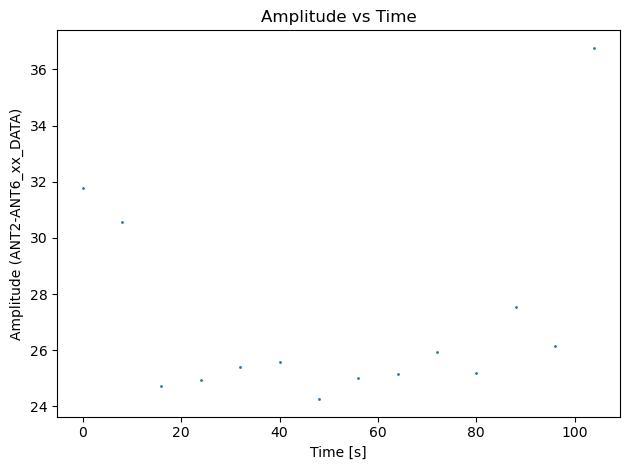

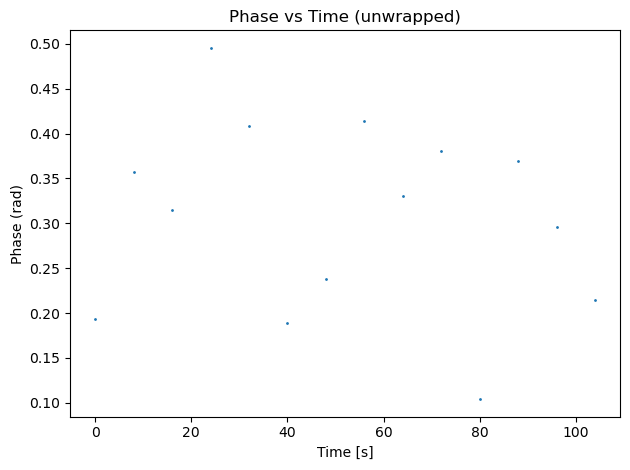

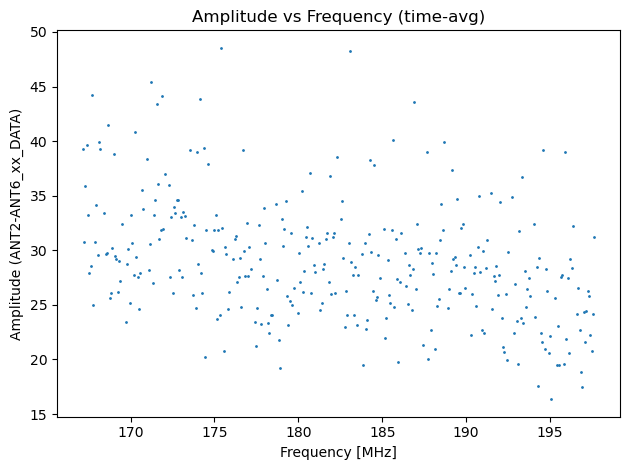

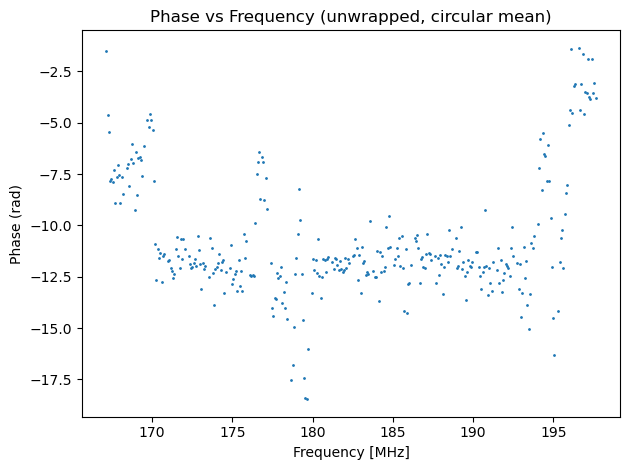

In [20]:
# --- Set Parameters Here ---

# Input file (MS or UVFITS format)
INPUT_FILE = "hyp_1184702048_ionosub_ssins_30l_src8k_300it_8s_80kHz_i1000.uvfits"

# Antenna 1 (name or index)
ANT1 = 2

# Antenna 2 (name or index)
ANT2 = 6

# Correlation to plot (e.g. XX, XY, YY, NN, EE, NE, EN)
CORR = 'xx'

# Column to plot (DATA, MODEL_DATA, CORRECTED_DATA)
COL = 'DATA'

# Time binning factor
TIMEBIN = 1

# Channel binning factor
CHANBIN = 1

# Use weights for averaging
USE_WEIGHTS = False

# Chunk size for MS processing
CHUNKSIZE = 100000

# Force input format (auto, ms, uvfits)
FORMAT = 'auto'

# --- End of Parameters ---

# Call the function using configuration parameters

results = run_processing_and_plotting(
    input_file=INPUT_FILE,
    ant1=ANT1,
    ant2=ANT2,
    corr=CORR,
    col=COL,
    timebin=TIMEBIN,
    chanbin=CHANBIN,
    use_weights=USE_WEIGHTS,
    chunksize=CHUNKSIZE,
    format_type=FORMAT
)

In [ ]:
# --- Set Parameters Here ---

# Input file (MS or UVFITS format)
INPUT_FILE = "L253456_SAP000_002_time1.flagged.5ch8s.dical.MS"

# Antenna 1 (name or index)
ANT1 = 2

# Antenna 2 (name or index)
ANT2 = 6

# Correlation to plot (e.g.  XX, XY, YX, YY, RR, RL, LR, LL, default is XX)
CORR = 'XX'

# Column to plot (DATA, MODEL_DATA, CORRECTED_DATA)
COL = 'DATA'

# Time binning factor
TIMEBIN = 1

# Channel binning factor
CHANBIN = 1

# Use weights for averaging
USE_WEIGHTS = True

# Chunk size for MS processing
CHUNKSIZE = 100000

# Force input format (auto, ms, uvfits)
FORMAT = 'auto'

# --- End of Parameters ---

# Call the function using configuration parameters

results = run_processing_and_plotting(
    input_file=INPUT_FILE,
    ant1=ANT1,
    ant2=ANT2,
    corr=CORR,
    col=COL,
    timebin=TIMEBIN,
    chanbin=CHANBIN,
    use_weights=USE_WEIGHTS,
    chunksize=CHUNKSIZE,
    format_type=FORMAT
)